In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from datasim.ecg.ecg_simulate import *
from datasim.scg.scg_simulate import *
import pywt

In [32]:
scg_l = []
for i in range(10):
    scg = scg_simulate(duration=1, heart_rate=70)
    scg_l.append(scg.flatten())

In [2]:
wavelet = pywt.Wavelet('sym4')
phi, psi, x = wavelet.wavefun(level=10)

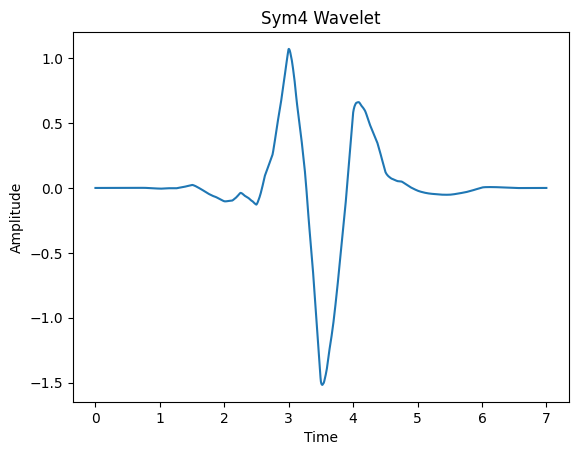

In [3]:
plt.plot(x, psi)
plt.title('Sym4 Wavelet')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()